In [243]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

path = 'kaggle/input'
# path = '/kaggle/input'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input\holidays_events.csv
kaggle/input\oil.csv
kaggle/input\sample_submission.csv
kaggle/input\stores.csv
kaggle/input\test.csv
kaggle/input\train.csv
kaggle/input\transactions.csv


In [244]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [245]:
stores = pd.read_csv(os.path.join(path, 'stores.csv'))
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [246]:
print(f'store_nbr: {np.sort(train_df['store_nbr'].unique())}\nlength: {len(train_df['store_nbr'].unique())}\n')

print(f'family: {np.sort(train_df['family'].unique())}\nlength: {len(train_df['family'].unique())}\n')

print(f'cluster: {np.sort(stores['cluster'].unique())}\n')

store_nbr: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
length: 54

family: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
length: 33

cluster: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]



In [247]:
oil = pd.read_csv(os.path.join(path, 'oil.csv'))
oil['date'] = pd.to_datetime(oil['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].ffill()
oil['dcoilwtico'] = oil['dcoilwtico'].bfill()
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [248]:
holiday_events = pd.read_csv(os.path.join(path, 'holidays_events.csv'))

holiday_events = holiday_events[holiday_events['transferred'] == False]
holiday_events['holiday'] = 1
holiday_events.head()

,date,type,locale,locale_name,description,transferred,holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1


In [249]:
store_nbr_cat = train_df['store_nbr'].astype('category').cat
store_nbr_categories = store_nbr_cat.categories

family_cat = train_df['family'].astype('category').cat
family_categories = family_cat.categories

print(f'store_nbr categories: {store_nbr_categories}')
print(f'family categories: {family_categories}')

store_nbr categories: Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54],
      dtype='int64')
family categories: Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
       'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
      dtype='object')


In [264]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.preprocessing import StandardScaler


def get_location(df):
    df = df.merge(stores[['store_nbr', 'state', 'city']], on='store_nbr', how='left')
    
    return df

def get_oil(df):
    df = df.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
    
    df['dcoilwtico'] = df['dcoilwtico'].ffill()
    df['dcoilwtico'] = df['dcoilwtico'].bfill()
    
    return df

def get_holiday(df):
    df = df.merge(holiday_events[holiday_events['type'] == 'National'][['date', 'holiday']], on='date', how='left')
    df = df.merge(holiday_events[holiday_events['type'] == 'Regional'][['date', 'locale_name', 'holiday']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')
    df = df.merge(holiday_events[holiday_events['type'] == 'Local'][['date', 'locale_name', 'holiday']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')
    
    df['holiday'] = df['holiday'] | df['holiday_y'] | df['holiday_x']
    df = df.drop(columns=['holiday_x', 'holiday_y', 'locale_name_x', 'locale_name_y'])
    df['holiday'] = df['holiday'].fillna(0).astype(int)
    
    return df

def get_seasonality(df, order=1, min_date=pd.to_datetime('2013-01-01'), max_date=pd.to_datetime('2017-08-31')):
    uniq_idx = pd.date_range(min_date, max_date, freq='D')

    fourier = CalendarFourier(freq='YE', order=order)

    dp = DeterministicProcess(
        index = uniq_idx,
        order = 0,
        constant = False,
        seasonal = True,
        additional_terms = [fourier],
        drop = False
    )

    det_feats = dp.in_sample()

    df = df.merge(det_feats, left_on='date', right_index=True, how='left')

    return df

def get_lags(df, lags = [1]):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    
    return df


def preprocess(df, proc_date=None, test=False):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    df = get_location(df)
    df = get_oil(df)
    df = get_holiday(df)
    df = get_seasonality(df, order=4)
    df = get_lags(df, lags=[1, 7])

    df['store_nbr'] = df['store_nbr'].apply(lambda x: store_nbr_categories.get_loc(x))
    df['family'] = df['family'].apply(lambda x: family_categories.get_loc(x))

    if proc_date is not None:
        df = df[df['date'] == proc_date]

    df = df.drop(columns=['state', 'city', 'date', 'id'])
    df = df.dropna(subset=['sales_lag_1', 'sales_lag_7'])

    if not test:
        df = df.dropna(subset=['sales'])

    for col in ['sales', 'sales_lag_1', 'sales_lag_7']:
        df[col] = np.log1p(df[col])

    df['dcoilwtico'] = (df['dcoilwtico'] - 67.8197) / 25.6708

    cols = df.columns.tolist()
    cols = cols[:2] + cols[-2:] + cols[2:-2]
    df = df[cols]

    return df

In [251]:
# x = preprocess(train_df)
x = train_df.copy()
x['date'] = pd.to_datetime(x['date'])
x = x.merge(stores[['store_nbr', 'city', 'state']], on='store_nbr', how='left')
x = get_oil(x)
x = get_holiday(x)
# x.sample(1000, random_state=42).to_csv('train_preprocessed.csv', index=False)

In [252]:
combos = x[['store_nbr', 'family']].drop_duplicates().reset_index(drop=True)

combo_sample = x.merge(combos.sample(10, random_state=42), on=['store_nbr', 'family'], how='inner')

combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16840 entries, 0 to 16839
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           16840 non-null  int64         
 1   date         16840 non-null  datetime64[ns]
 2   store_nbr    16840 non-null  int64         
 3   family       16840 non-null  object        
 4   sales        16840 non-null  float64       
 5   onpromotion  16840 non-null  int64         
 6   city         16840 non-null  object        
 7   state        16840 non-null  object        
 8   dcoilwtico   16840 non-null  float64       
 9   holiday      16840 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 1.3+ MB


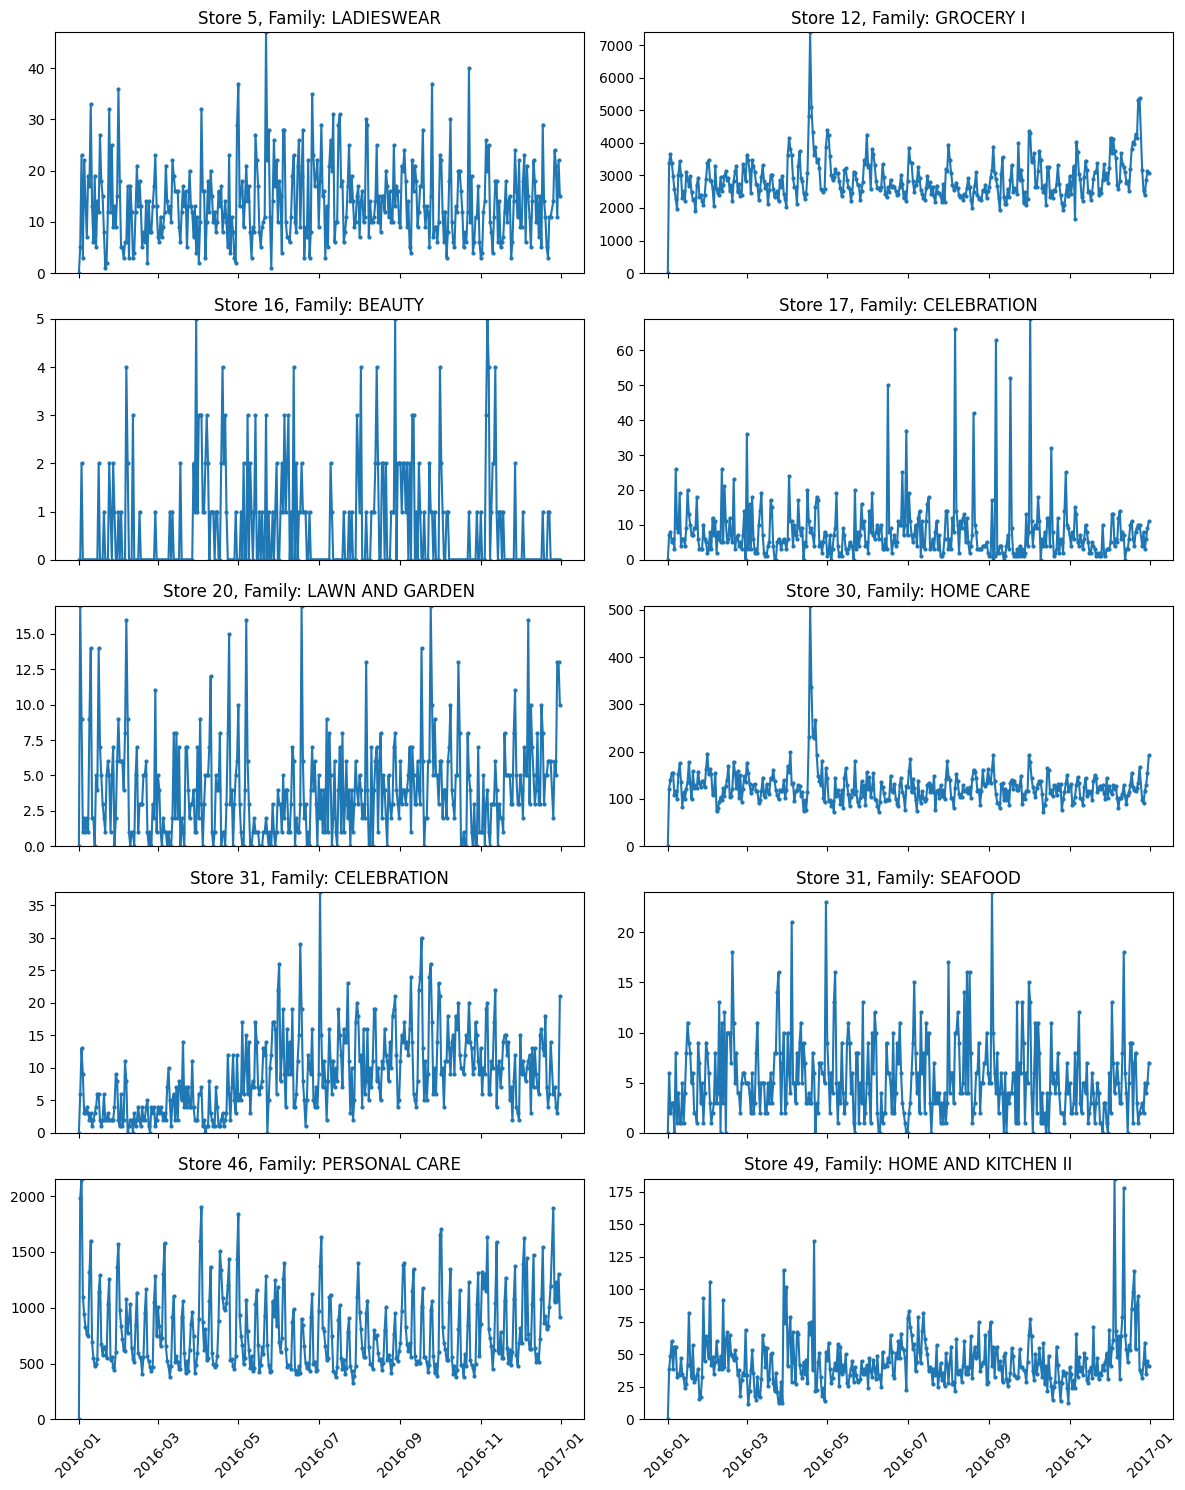

In [253]:
combo_sample['date'] = pd.to_datetime(combo_sample['date'])
combo_sample = combo_sample[combo_sample['date'].dt.year == 2016]
groups = combo_sample.groupby(['store_nbr', 'family'])

fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)
axs = axs.flatten()

for ax, ((store_nbr, family), group) in zip(axs, groups):
    group = group.sort_values('date')
    ax.plot(group['date'], group['sales'], marker='o', markersize=2)
    ax.set_title(f'Store {store_nbr}, Family: {family}')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(group['sales'].min(), group['sales'].max())

plt.tight_layout()
plt.show()

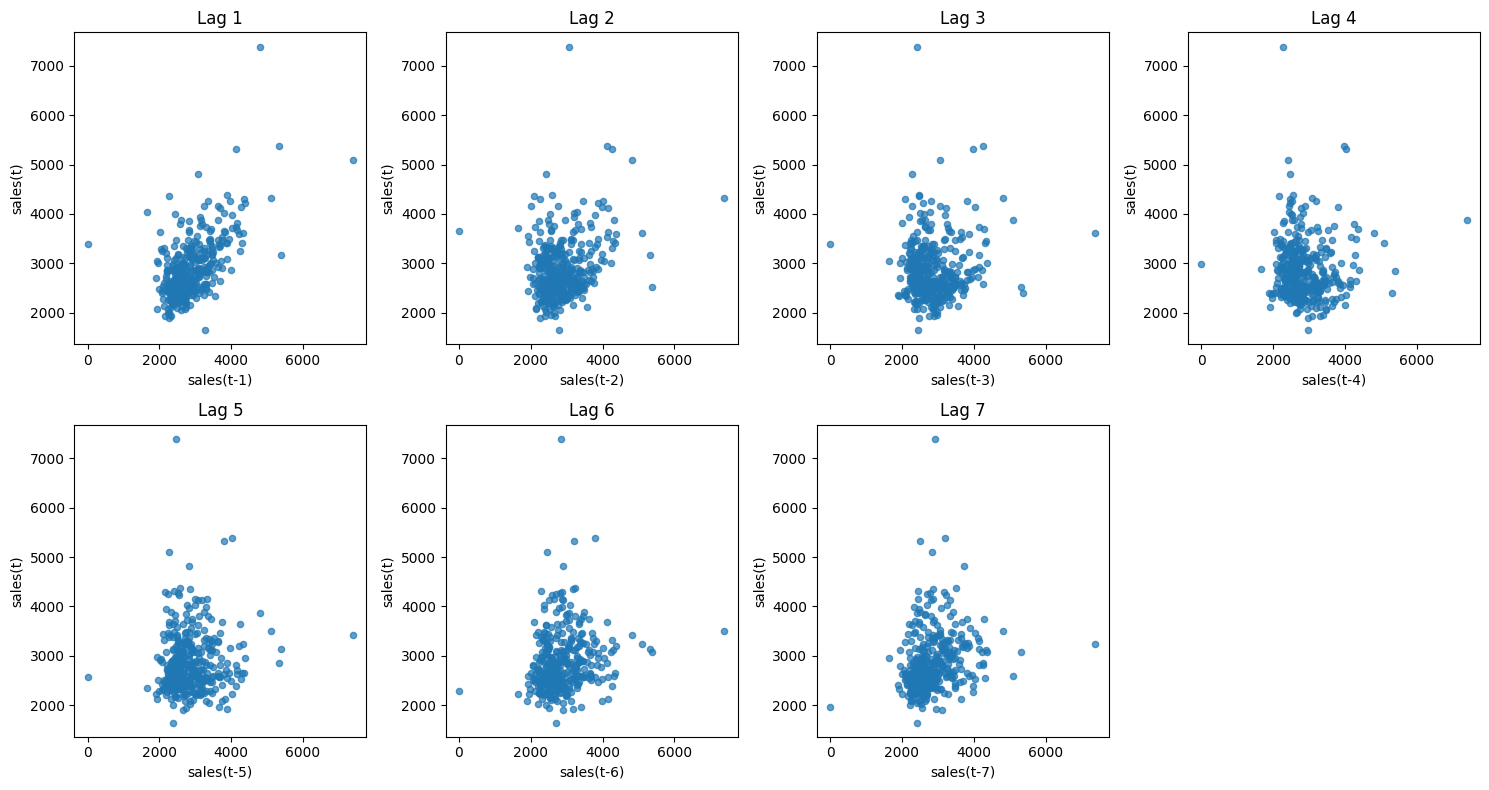

In [254]:
# Get the first group from the groups object and sort by date
first_key, first_group = list(groups)[1]
first_group = first_group.sort_values('date')
sales = first_group['sales'].reset_index(drop=True)

# Create lag plots for lags 1 through 7
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for lag in range(1, 8): 
    shifted = sales.shift(lag)
    # Ensure we only compare valid (non-NaN) points
    valid = shifted.notna()
    axes[lag - 1].scatter(shifted[valid], sales[valid], s=20, alpha=0.7)
    axes[lag - 1].set_title(f'Lag {lag}')
    axes[lag - 1].set_xlabel(f'sales(t-{lag})')
    axes[lag - 1].set_ylabel('sales(t)')

# Disable the unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

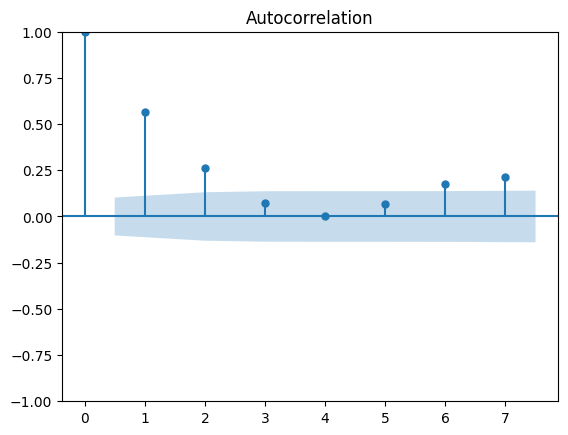

In [255]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales, lags=7)
plt.show()

In [256]:
# Source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

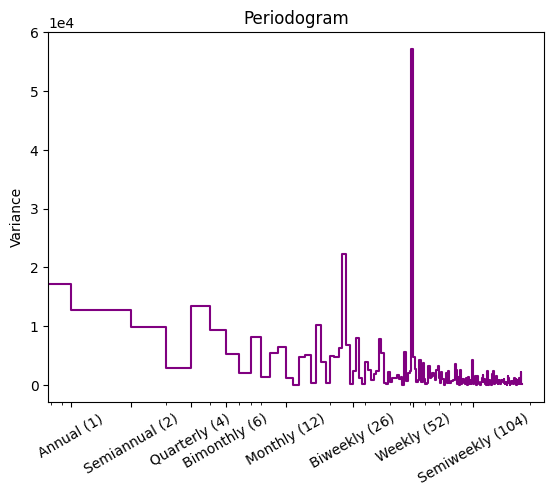

In [257]:
plot_periodogram(sales)

In [258]:
# test_x = pd.read_csv(os.path.join(path, 'test.csv'))
# test_x = preprocess(test_x, test_set=True)

# test_x.to_csv('test_preprocessed.csv', index=True)

In [259]:
train_x = preprocess(train_df)
train_x.sample(10000, random_state=42).to_csv('train_preprocessed.csv', index=True)
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 23 columns):
 #   Column              Dtype  
---  ------              -----  
 0   store_nbr           int64  
 1   family              int64  
 2   sales_lag_1         float64
 3   sales_lag_7         float64
 4   sales               float64
 5   onpromotion         int64  
 6   dcoilwtico          float64
 7   holiday             int64  
 8   s(1,7)              float64
 9   s(2,7)              float64
 10  s(3,7)              float64
 11  s(4,7)              float64
 12  s(5,7)              float64
 13  s(6,7)              float64
 14  s(7,7)              float64
 15  sin(1,freq=YE-DEC)  float64
 16  cos(1,freq=YE-DEC)  float64
 17  sin(2,freq=YE-DEC)  float64
 18  cos(2,freq=YE-DEC)  float64
 19  sin(3,freq=YE-DEC)  float64
 20  cos(3,freq=YE-DEC)  float64
 21  sin(4,freq=YE-DEC)  float64
 22  cos(4,freq=YE-DEC)  float64
dtypes: float64(19), int64(4)
memory usage: 526.6 MB


In [260]:
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_col='sales'):
        self.dataframe = dataframe
        self.target_col = target_col
        self.features = dataframe.drop(columns=[target_col])
        self.targets = dataframe[target_col].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        vals = self.features.iloc[idx].values
        store_nbr = torch.tensor(vals[0], dtype=torch.long)
        family = torch.tensor(vals[1], dtype=torch.long)
        x_cont = torch.tensor(vals[2:6], dtype=torch.float32)
        x_time = torch.tensor(vals[6:], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return store_nbr, family, x_cont, x_time, y
    
def load_data(df, ttsplit=False, **kwargs):
    df = preprocess(df)
    if ttsplit:
        train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
        train_dataset = CustomDataset(train_df)
        val_dataset = CustomDataset(val_df)
        return DataLoader(train_dataset, **kwargs), DataLoader(val_dataset, **kwargs)
    dataset = CustomDataset(df)
    return DataLoader(dataset, **kwargs)
    
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        log_y_pred = torch.log1p(y_pred)
        log_y_true = torch.log1p(y_true)
        loss = torch.mean((log_y_pred - log_y_true) ** 2)
        return torch.sqrt(loss)

In [271]:
# class Standardize(torch.nn.Module):
#     def __init__(self, mean, std):
#         super().__init__()
#         self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32))
#         self.register_buffer("std",  torch.tensor(std,  dtype=torch.float32))

#     def forward(self, x):
#         return (x - self.mean) / self.std

class SalesModel(torch.nn.Module):
    def __init__(self, num_stores, store_embed, num_families, fam_embed, input_size):
        super().__init__()
        self.store_embedding = torch.nn.Embedding(num_stores, store_embed)
        self.family_embedding = torch.nn.Embedding(num_families, fam_embed)
        # self.standardize = Standardize(scaler.mean_.astype(np.float32), scaler.scale_.astype(np.float32))
        self.fc1 = torch.nn.Linear(store_embed + fam_embed + input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, store_nbr, family, x_cont, x_time):
        store_emb = self.store_embedding(store_nbr)
        family_emb = self.family_embedding(family)
        # x_stand = self.standardize(x_cont)
        x = torch.cat([store_emb, family_emb, x_cont, x_time], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

In [262]:
from pathlib import Path
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MSELoss


def train(
    exp_dir: str = "logs",
    num_epoch: int = 50,
    lr: float = 1e-3,
    batch_size: int = 128,
    seed: int = 42,
    **kwargs,
):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    model_name = 'sales_model'

    # set random seed so each run is deterministic
    torch.manual_seed(seed)
    np.random.seed(seed)

    # directory with timestamp to save tensorboard logs and model checkpoints
    log_dir = Path(exp_dir) / f"{model_name}_{datetime.now().strftime('%m%d_%H%M%S')}"
    logger = SummaryWriter(log_dir)

    model = SalesModel(
        num_stores=54,
        store_embed=4,
        num_families=33,
        fam_embed=4,
        input_size=20,
    )
    model = model.to(device)
    model.train()

    df = pd.read_csv(os.path.join(path, 'train.csv'))
    train_data, val_data = load_data(df, ttsplit=True, shuffle=True, batch_size=batch_size, num_workers=0)

    # create loss function and optimizer
    loss_func = MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    global_step = 0

    print('Training started...\n')

    # training loop
    for epoch in range(num_epoch):
        metrics = {'train_loss': [], 'val_loss': []}

        for store_nbr, family, x_cont, x_time, y in train_data:
            store_nbr, family, x_cont, x_time = store_nbr.to(device), family.to(device), x_cont.to(device), x_time.to(device)
            y = y.to(device)

            pred = model(store_nbr, family, x_cont, x_time)
            loss = loss_func(pred, y)
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if global_step % 100 == 0:
                train_loss = torch.as_tensor(metrics["train_loss"]).mean()
                logger.add_scalar("train_loss", train_loss, global_step)
                if global_step % 5000 == 0:
                    print(f"Epoch: {epoch}, Step {global_step}: train_loss={train_loss:.4f}")
                metrics["train_loss"] = []

            global_step += 1

        with torch.inference_mode():
            for store_nbr, family, x_cont, x_time, y in val_data:
                store_nbr, family, x_cont, x_time = store_nbr.to(device), family.to(device), x_cont.to(device), x_time.to(device)
                y = y.to(device)

                pred = model(store_nbr, family, x_cont, x_time)
                loss = loss_func(pred, y)
                metrics['val_loss'].append(loss.item())

        epoch_train_loss = torch.as_tensor(metrics["train_loss"]).mean()
        epoch_val_loss = torch.as_tensor(metrics["val_loss"]).mean()

        logger.add_scalar("train_loss", epoch_train_loss, global_step)
        logger.add_scalar("val_loss", epoch_val_loss, global_step)

        print(
            f"Epoch {epoch + 1:2d} / {num_epoch:2d}: "
            f"train_loss={epoch_train_loss:.4f} "
            f"val_loss={epoch_val_loss:.4f}\n"
        )

    # save and overwrite the model in the root directory
    torch.save(model.state_dict(), f'{model_name}.th')

    # save a copy of model weights in the log directory
    torch.save(model.state_dict(), log_dir / f'{model_name}.th')
    
    print(f"Model saved to {log_dir / f'{model_name}.th'}")

In [228]:
def evaluate(
    model_path: str = "sales_model.th",
    batch_size: int = 128,
    **kwargs,
):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        print("CUDA not available, using CPU")
        device = torch.device("cpu")

    model = SalesModel(
        num_stores=54,
        store_embed=4,
        num_families=33,
        fam_embed=4,
        input_size=20,
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    train_df = pd.read_csv(os.path.join(path, 'train.csv'))
    test_df = pd.read_csv(os.path.join(path, 'test.csv'))
    test_df['sales'] = np.nan

    merged_df = pd.concat([train_df, test_df], ignore_index=True)
    merged_df['date'] = pd.to_datetime(merged_df['date'])

    proc_date = merged_df[merged_df['sales'].isna()]['date'].min()
    context_date = proc_date - pd.Timedelta(days=8)
    merged_df = merged_df[merged_df['date'] >= context_date]

    print(f'Context date: {context_date}')
    print(f'Processing date: {proc_date}')    

    df = preprocess(merged_df, proc_date, test=True)
    test_data = DataLoader(CustomDataset(df, target_col='sales'), batch_size=batch_size, shuffle=False, num_workers=0)

    predictions = []
    
    with torch.inference_mode():
        for store_nbr, family, x_cont, x_time, _ in test_data:
            store_nbr, family, x_cont, x_time = store_nbr.to(device), family.to(device), x_cont.to(device), x_time.to(device)
            pred = model(store_nbr, family, x_cont, x_time)
            pred = torch.expm1(pred)
            predictions.append(pred.cpu().numpy())

    predictions = np.concatenate(predictions)
    merged_df.loc[merged_df['date'] == proc_date, 'sales'] = predictions
    
    return predictions

In [275]:
model_path = 'sales_model.th'

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("CUDA not available, using CPU")
    device = torch.device("cpu")

model = SalesModel(
    num_stores=54,
    store_embed=4,
    num_families=33,
    fam_embed=4,
    input_size=20,
)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))
test_df['sales'] = np.nan

merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df['date'] = pd.to_datetime(merged_df['date'])

start_date = merged_df[merged_df['sales'].isna()]['date'].min()
end_date = merged_df['date'].max()
context_date = start_date - pd.Timedelta(days=8)
merged_df = merged_df[merged_df['date'] >= context_date]

print(f'Context date: {context_date}')

for proc_date in pd.date_range(start_date, end_date):
    print(f'Processing date: {proc_date}')

    df = preprocess(merged_df, proc_date, test=True)
    # df = preprocess(merged_df, test=True)
    # df.to_excel('eval_processed.xlsx', index=False)
    # break
    test_data = DataLoader(CustomDataset(df, target_col='sales'), batch_size=128, shuffle=False, num_workers=0)

    predictions = []

    with torch.inference_mode():
        for store_nbr, family, x_cont, x_time, _ in test_data:
            store_nbr, family, x_cont, x_time = store_nbr.to(device), family.to(device), x_cont.to(device), x_time.to(device)
            pred = model(store_nbr, family, x_cont, x_time)
            pred = torch.expm1(pred)
            predictions.append(pred.cpu().numpy())

    predictions = np.concatenate(predictions)
    predictions = np.clip(predictions, 0, None)
    merged_df.loc[merged_df['date'] == proc_date, 'sales'] = predictions

merged_df.to_excel('evaluation.xlsx', index=False)

submission = merged_df[merged_df['date'] > pd.to_datetime('2017-08-15')][['id', 'sales']]
submission.to_csv('submission.csv', index=False)

Context date: 2017-08-08 00:00:00
Processing date: 2017-08-16 00:00:00
Processing date: 2017-08-17 00:00:00
Processing date: 2017-08-18 00:00:00
Processing date: 2017-08-19 00:00:00
Processing date: 2017-08-20 00:00:00
Processing date: 2017-08-21 00:00:00
Processing date: 2017-08-22 00:00:00
Processing date: 2017-08-23 00:00:00
Processing date: 2017-08-24 00:00:00
Processing date: 2017-08-25 00:00:00
Processing date: 2017-08-26 00:00:00
Processing date: 2017-08-27 00:00:00
Processing date: 2017-08-28 00:00:00
Processing date: 2017-08-29 00:00:00
Processing date: 2017-08-30 00:00:00
Processing date: 2017-08-31 00:00:00


In [240]:
z = preprocess(train_df)

z = z[z['store_nbr'] == 0]
z = z[z['family'] == 30]

z.to_excel('eval_counter.xlsx', index=False)

In [192]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))
test_df['sales'] = np.nan

merged_df = pd.concat([train_df, test_df], ignore_index=True)
merged_df['date'] = pd.to_datetime(merged_df['date'])

proc_date = merged_df[merged_df['sales'].isna()]['date'].min()
print(f'Processing date: {proc_date}')
context_date = proc_date - pd.Timedelta(days=10)
print(f'Context date: {context_date}')

merged_df = merged_df[merged_df['date'] >= context_date]

df = preprocess(merged_df, proc_date, test=True)

merged_df.to_excel('merged_df.xlsx', index=False, sheet_name='merged_preprocessed')
df.to_excel('eval_df.xlsx', index=False, sheet_name='df_preprocessed')

Processing date: 2017-08-16 00:00:00
Context date: 2017-08-06 00:00:00


In [273]:
exp_dir = "logs"
num_epoch = 10
lr = 1e-3
batch_size = 256
seed = 42

train(
    exp_dir=exp_dir,
    num_epoch=num_epoch,
    lr=lr,
    batch_size=batch_size,
    seed=seed,
)

Training started...

Epoch: 0, Step 0: train_loss=17.1852
Epoch: 0, Step 5000: train_loss=0.2189
Epoch  1 / 10: train_loss=0.1773 val_loss=0.1857

Epoch: 1, Step 10000: train_loss=0.1924
Epoch: 1, Step 15000: train_loss=0.1631
Epoch  2 / 10: train_loss=0.1643 val_loss=0.1728

Epoch: 2, Step 20000: train_loss=0.1687
Epoch: 2, Step 25000: train_loss=0.1667
Epoch  3 / 10: train_loss=0.1769 val_loss=0.1670

Epoch: 3, Step 30000: train_loss=0.1645
Epoch: 3, Step 35000: train_loss=0.1561
Epoch  4 / 10: train_loss=0.1637 val_loss=0.1595

Epoch: 4, Step 40000: train_loss=0.1629
Epoch: 4, Step 45000: train_loss=0.1574
Epoch  5 / 10: train_loss=0.1570 val_loss=0.1570

Epoch: 5, Step 50000: train_loss=0.1534
Epoch: 5, Step 55000: train_loss=0.1546
Epoch  6 / 10: train_loss=0.1416 val_loss=0.1545

Epoch: 6, Step 60000: train_loss=0.1496
Epoch: 6, Step 65000: train_loss=0.1588
Epoch  7 / 10: train_loss=0.1538 val_loss=0.1545

Epoch: 7, Step 70000: train_loss=0.1564
Epoch  8 / 10: train_loss=0.1394 